In [21]:
import torch
from torch import nn
from lightning import pytorch as pl
from torch.utils.data import DataLoader, Dataset, random_split
import numpy as np

In [34]:
# Define a simple dataset
class SimpleDataset(Dataset):
    def __init__(self, num_samples=2000):
        self.x = np.linspace(-2, 2, num_samples)
        self.y = 4 * self.x**2 + 5 * self.x + 2 + 0.3 * np.random.randn(num_samples)
        self.x = self.x.astype(np.float32).reshape(-1, 1)
        self.y = self.y.astype(np.float32).reshape(-1, 1)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

# Define the model
class SimpleModel(pl.LightningModule):
    def __init__(self):
        super(SimpleModel, self).__init__()
        self.layer_1 = nn.Linear(1, 15)
        self.layer_2 = nn.Linear(15, 15)
        self.layer_3 = nn.Linear(15, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.layer_1(x))
        x = self.relu(self.layer_2(x))
        x = self.layer_3(x)
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)
        loss = nn.MSELoss()(y_hat, y)
        self.log('train_loss', loss)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.001)


In [43]:
torch.manual_seed(1)
np.random.seed(1)

# Prepare data
dataset = SimpleDataset()
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

# Train the model
model = SimpleModel()
trainer = pl.Trainer(max_epochs=200)
trainer.fit(model, train_loader, val_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type   | Params
-----------------------------------
0 | layer_1 | Linear | 30    
1 | layer_2 | Linear | 240   
2 | layer_3 | Linear | 16    
3 | relu    | ReLU   | 0     
-----------------------------------
286       Trainable params
0         Non-trainable params
286       Total params
0.001     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


Epoch 199: 100%|██████████| 50/50 [00:00<00:00, 164.59it/s, loss=0.0911, v_num=1366484]

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 199: 100%|██████████| 50/50 [00:00<00:00, 160.37it/s, loss=0.0911, v_num=1366484]


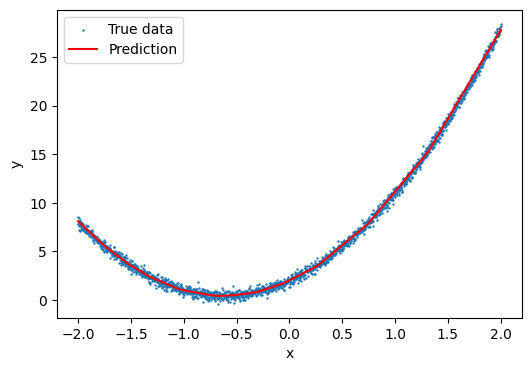

In [46]:
# Test the model
test_x = np.linspace(-2, 2, 100).astype(np.float32).reshape(-1, 1)
test_x_tensor = torch.tensor(test_x)
model.eval()
with torch.no_grad():
    test_y_pred = model(test_x_tensor).numpy()

# Visualize the results
plt.figure(figsize=(6, 4))
plt.scatter(dataset.x, dataset.y, s=0.5, label='True data')
plt.plot(test_x, test_y_pred, color='r', label='Prediction')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()